# ITU-ML5G-PS-005-KDDI Task1

In [1]:
import gc
import numpy as np
import pandas as pd
from tools.preprocessing import Processor
from tools.generator import ReccurentTrainingGenerator, ReccurentTestGenerator

2022-11-22 06:35:36.088845: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-22 06:35:36.092747: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 06:35:36.092763: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Load data

In [2]:
train_0 = pd.read_csv('data/ML5G-PS-005_train_0.csv', index_col=0, header=0)
train_1 = pd.read_csv('data/ML5G-PS-005_train_1.csv', index_col=0, header=0)
train_2 = pd.read_csv('data/ML5G-PS-005_train_2.csv', index_col=0, header=0)
train_3 = pd.read_csv('data/ML5G-PS-005_train_3.csv', index_col=0, header=0)
train_4 = pd.read_csv('data/ML5G-PS-005_train_4.csv', index_col=0, header=0)
train_5 = pd.read_csv('data/ML5G-PS-005_train_5.csv', index_col=0, header=0)
train_data = pd.concat([train_0, train_1, train_2, train_3, train_4, train_5])
del train_0, train_1, train_2, train_3, train_4, train_5

test_0 = pd.read_csv('data/ML5G-PS-005_test_0.csv', index_col=0, header=0)
test_1 = pd.read_csv('data/ML5G-PS-005_test_1.csv', index_col=0, header=0)
test_2 = pd.read_csv('data/ML5G-PS-005_test_2.csv', index_col=0, header=0)
test_data = pd.concat([test_0, test_1, test_2])
del test_0, test_1, test_2
gc.collect()

0

# Preprocess

In [3]:
preprocessor = Processor(train_data, test_data)

In [5]:
X, Y, test_X, test_Y = preprocessor.get_scaled_data()
test_labels = preprocessor.test_label.values

# Train

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [7]:
timesteps = 15
delay = 45
batch_size = 64
input_dim = X.shape[-1]

In [8]:
input = Input(shape=(timesteps, input_dim))
lstm = LSTM(256, input_shape=(timesteps, input_dim), return_sequences=True)(input)
lstm = LSTM(256)(lstm)
dropout = Dropout(0.5)(lstm)
dense = Dense(1)(dropout)
model = Model(inputs=input, outputs=dense)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

2022-11-22 06:36:02.665519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 06:36:02.665542: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 06:36:02.665556: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hakiitakeru-XPS-13-9305): /proc/driver/nvidia/version does not exist
2022-11-22 06:36:02.665811: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 3325)]        0         
                                                                 
 lstm (LSTM)                 (None, 15, 256)           3667968   
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 4,193,537
Trainable params: 4,193,537
Non-trainable params: 0
_________________________________________________________________


In [9]:
train_X = X[:500*70]
train_Y = Y[:500*70]
val_X = X[500*70:]
val_Y = Y[500*70:]

In [10]:
train_generator = ReccurentTrainingGenerator(train_X, train_Y, batch_size, timesteps, delay)
val_generator = ReccurentTrainingGenerator(val_X, val_Y, batch_size, timesteps, delay)

In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [12]:
history = model.fit(x=train_generator, epochs=20, verbose=1, callbacks=callback, validation_data=val_generator)

Epoch 1/20
79/79 [==============================] - 11s 109ms/step - loss: 0.2127 - val_loss: 0.0088
Epoch 2/20
79/79 [==============================] - 8s 102ms/step - loss: 0.0146 - val_loss: 0.0028
Epoch 3/20
79/79 [==============================] - 8s 99ms/step - loss: 0.0074 - val_loss: 0.0023
Epoch 4/20
79/79 [==============================] - 8s 99ms/step - loss: 0.0055 - val_loss: 0.0026
Epoch 5/20
79/79 [==============================] - 8s 99ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 6/20
79/79 [==============================] - 8s 103ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 7/20
79/79 [==============================] - 8s 105ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 8/20
79/79 [==============================] - 8s 103ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 9/20
79/79 [==============================] - 8s 102ms/step - loss: 0.0039 - val_loss: 0.0020


# Evaluation

In [13]:
from tools.metrics import Evaluation

In [14]:
test_generator = ReccurentTestGenerator(test_X, batch_size, timesteps, delay)

In [15]:
pred = model.predict(test_generator)
pred = pred.reshape(300, -1)

47/47 [==============================] - 2s 39ms/step


In [18]:
test_Y = test_Y.values.reshape(300, -1)

In [19]:
evaluation = Evaluation(pred, test_Y, test_labels, timesteps, delay, threshold=0.3)

In [20]:
evaluation.MSE()

0.002904193962487335

In [21]:
evaluation.score()

[[225   0]
 [ 17  58]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       225
           1       1.00      0.77      0.87        75

    accuracy                           0.94       300
   macro avg       0.96      0.89      0.92       300
weighted avg       0.95      0.94      0.94       300



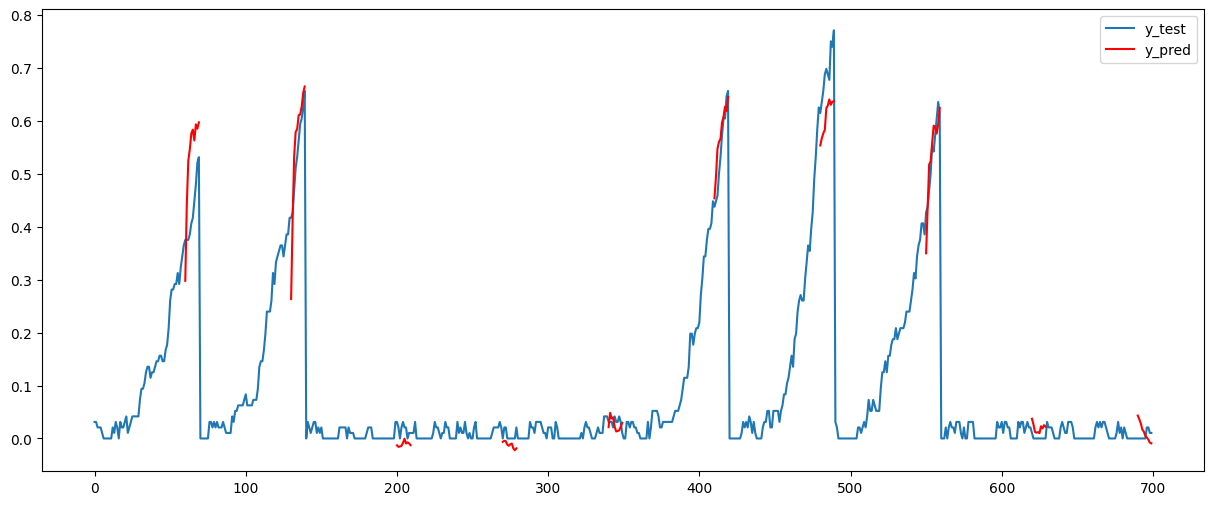

In [22]:
evaluation.visualization()

# Remove 0 metrics

In [23]:
X, Y, test_X, test_Y = preprocessor.get_removed_data()
test_labels = preprocessor.test_label.values

In [24]:
timesteps = 15
delay = 45
batch_size = 64
input_dim = X.shape[-1]

In [25]:
input = Input(shape=(timesteps, input_dim))
lstm = LSTM(256, input_shape=(timesteps, input_dim), return_sequences=True)(input)
lstm = LSTM(256)(lstm)
dropout = Dropout(0.5)(lstm)
dense = Dense(1)(dropout)
model_remove = Model(inputs=input, outputs=dense)
model_remove.compile(loss='mean_squared_error', optimizer='adam')
model_remove.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 1723)]        0         
                                                                 
 lstm_2 (LSTM)               (None, 15, 256)           2027520   
                                                                 
 lstm_3 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,553,089
Trainable params: 2,553,089
Non-trainable params: 0
_________________________________________________________________


In [26]:
train_X = X[:500*70]
train_Y = Y[:500*70]
val_X = X[500*70:]
val_Y = Y[500*70:]

In [27]:
train_generator = ReccurentTrainingGenerator(train_X, train_Y, batch_size, timesteps, delay)
val_generator = ReccurentTrainingGenerator(val_X, val_Y, batch_size, timesteps, delay)

In [28]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [30]:
history = model_remove.fit(x=train_generator, epochs=20, verbose=1, callbacks=callback, validation_data=val_generator)

Epoch 1/20
79/79 [==============================] - 8s 75ms/step - loss: 0.2144 - val_loss: 0.0120
Epoch 2/20
79/79 [==============================] - 5s 69ms/step - loss: 0.0152 - val_loss: 0.0034
Epoch 3/20
79/79 [==============================] - 5s 69ms/step - loss: 0.0080 - val_loss: 0.0029
Epoch 4/20
79/79 [==============================] - 5s 69ms/step - loss: 0.0065 - val_loss: 0.0024
Epoch 5/20
79/79 [==============================] - 6s 70ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 6/20
79/79 [==============================] - 6s 69ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 7/20
79/79 [==============================] - 6s 72ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 8/20
79/79 [==============================] - 6s 70ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 9/20
79/79 [==============================] - 6s 74ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 10/20
79/79 [==============================] - 6s 80ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 11/

In [31]:
test_generator = ReccurentTestGenerator(test_X, batch_size, timesteps, delay)

In [32]:
pred = model_remove.predict(test_generator)
pred = pred.reshape(300, -1)

47/47 [==============================] - 2s 30ms/step


In [33]:
test_Y = test_Y.values.reshape(300, -1)

In [35]:
evaluation = Evaluation(pred, test_Y, test_labels, timesteps, delay, threshold=0.3)

In [36]:
evaluation.MSE()

0.0029564547790372083

In [37]:
evaluation.score()

[[225   0]
 [ 14  61]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       225
           1       1.00      0.81      0.90        75

    accuracy                           0.95       300
   macro avg       0.97      0.91      0.93       300
weighted avg       0.96      0.95      0.95       300



In [38]:
X, Y, test_X, test_Y = preprocessor.get_diff_data()

In [39]:
X.shape

(42000, 329)

: 